# 주제 : 성별과 웃음 여부를 동시에 판단하는 모델을 만들어보자
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제의 데이터는 얼굴 데이터로 유명한 celeba dataset을 이용합니다.
  ![celeba dataset](https://storage.googleapis.com/tfds-data/visualization/fig/celeb_a-2.0.1.png)

     위의 이미지는 다음과 같은 것을 보여줍니다.  
    - 10,177 개의 신원 
    - 얼굴 이미지 수 202,599 개
    - 5 개의 랜드 마크 위치, 이미지 당 40 개의 바이너리 속성 주석
      - 성별
      - 큰 코
      - 매력적
      - 젊음
      - 웃음 여부
      - 모자 착용 여부
      - 안경 착요 여부
      - etc



- 데이터 출처:
 - [celeba dataset](https://www.tensorflow.org/datasets/catalog/celeb_a)
 - [celeba small](https://drive.google.com/file/d/1t2qIgpWdWX_n5OC8P2ZiDfPIQ98NY_PB/view?usp=sharing)

## 최종 목표

    - 작게 줄인 celeba 데이터를 이용하여 웃음, 성별 동시 구분
    - 한 모델에서 여러 결과에 대한 분석을 하는 방법
    - 큰 사진을 작게 줄이기

* 출제자 : 손근영 강사
---------------


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## Step 1. 도입전 기본 처리

### 문제 1. tfds를 이용하여 데이터셋 사용하기

In [3]:
# tfds를 이용하여 데이터셋 사용하기
import tensorflow_datasets as tfds
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

### 문제 2. celeba의 정보중 이용할 데이터만 추출

In [4]:
# celeba의 정보중 이용할 데이터만 추출
celeb_a = tfds.load('celeb_a')

Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteJZSYG5/celeb_a-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteJZSYG5/celeb_a-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteJZSYG5/celeb_a-test.tfrecord


Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [7]:
import imageio
from skimage.transform import resize

celeb_a_train, celeb_a_test = celeb_a['validation'], celeb_a['test']

train_images = []
train_lables = []
for tensor in tfds.as_numpy(celeb_a_train):
  isMale = tensor['attributes']['Male']
  isSmiling = tensor['attributes']['Smiling']

  label = np.array([isMale, isSmiling]).astype(np.int8)
  img = resize(tensor['image'], (190//1.5, 89//1.5))

  train_images.append(img)
  train_lables.append(label)

test_images = []
test_lables = []
for tensor in tfds.as_numpy(celeb_a_test):
  isMale = tensor['attributes']['Male']
  isSmiling = tensor['attributes']['Smiling']

  label = np.array([isMale, isSmiling]).astype(np.int8)
  img = resize(tensor['image'], (190//1.5, 89//1.5))

  test_images.append(img)
  test_lables.append(label)


In [8]:
len(test_images), len(train_images)

(19962, 19867)

In [6]:
190//1.5, 89//1.5

(126.0, 59.0)

### 문제 3. 데이터량 축소

In [10]:
# 데이터량 축소
m_s = []
f_s = []
m_n = []
f_n = []
for a, b in zip(test_images, test_lables):
  if b[0] and b[1]:
    m_s.append((a, b))
  elif not b[0] and b[1]:
    f_s.append((a, b))
  elif b[0] and not b[1]:
    m_n.append((a, b))
  elif not b[0] and not b[1]:
    f_n.append((a, b))

In [12]:
len(m_s), len(f_s), len(m_n), len(f_n)
total = m_s[:550] + f_s[:550] + m_n[:550] + f_n[:550]
len(total)

2200

In [15]:
import random
random.shuffle(total)
trains = total[:2000]
tests = total[2000:]
len(trains), len(tests)

(2000, 200)

In [19]:
train_images, train_labels = list(zip(*trains))
test_images, test_labels = list(zip(*tests))

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

### 문제 4. 사전 저장된 celeba small 데이터 확인

In [21]:
# 이미 저장된 celeba 데이터를 이용
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [24]:
!ls -al /gdrive/'My Drive'/'Colab Notebooks'/dataset/celeba_small.npz

-rw------- 1 root root 173961605 Dec 17 13:41 '/gdrive/My Drive/Colab Notebooks/dataset/celeba_small.npz'


In [25]:
#https://drive.google.com/file/d/1t2qIgpWdWX_n5OC8P2ZiDfPIQ98NY_PB/view?usp=sharing

!gdown --id 1t2qIgpWdWX_n5OC8P2ZiDfPIQ98NY_PB

Downloading...
From: https://drive.google.com/uc?id=1t2qIgpWdWX_n5OC8P2ZiDfPIQ98NY_PB
To: /content/celeba_small.npz
174MB [00:03, 50.6MB/s]


In [26]:
!ls -al /content/celeba_small.npz

-rw-r--r-- 1 root root 173961605 Dec 26 05:50 /content/celeba_small.npz


### 문제 5. celeba_small 데이터 살펴보기

In [38]:
# 데이터를 train에서 사람 이미지 한장과 label 정보 한개를 불러오는 코드를 작성해주세요. (x, y로 변수 대입)
celeba_small = np.load('/content/celeba_small.npz')
x = celeba_small['train_images'][3]
y = celeba_small['train_labels'][3]

### 문제 6. x와 y의 shape을 출력해보세요.

In [36]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
x.shape, y.shape

((72, 59, 3), (2,))

### 문제 7. x를 각각 plt를 통하여 출력하세요.

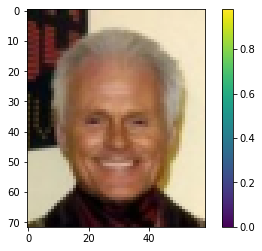

[1 1]


In [43]:
# x를 plt를 이용하여 출력하는 코드를 작성해보세요
plt.imshow(x)
plt.colorbar()
plt.show()
print(y)

### 문제 8. celeba_small.npz 데이터에서 학습, 테스트 데이터를 로드하세요.

In [40]:
# celeba_small.npz에서 train_images, test_images, train_labels, test_labels를 np array로 로드하세요.

celeba_small = np.load('/content/celeba_small.npz')
train_images = celeba_small['train_images']
train_labels = celeba_small['train_labels']

test_images = celeba_small['test_images']
test_labels = celeba_small['test_labels']

### 문제 9. train_images에서 0이 아닌 값들을 출력해보세요.

In [41]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요.
train_images[train_images != 0][:10]

array([0.02352941, 0.04313725, 0.05490196, 0.01960784, 0.03921569,
       0.05490196, 0.01977401, 0.03921569, 0.05114656, 0.02352941])

### 문제 10. train_images의 dtype을 출력해보세요.

In [44]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
train_images.dtype

dtype('float64')

## Step 2. 전처리

### 문제 11. 이미지 데이터의 범위 확인

In [48]:
# train_images, train_labels의 shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성하세요.
print(train_images.shape, test_images.shape)
print(train_images.dtype, test_images.dtype)

print(train_labels.shape, test_labels.shape)
print(train_labels.dtype, test_labels.dtype)

print(train_images[train_images != 0][:10])
print(test_images[test_images != 0][:10])

(2000, 72, 59, 3) (200, 72, 59, 3)
float64 float64
(2000, 2) (200, 2)
int8 int8
[0.02352941 0.04313725 0.05490196 0.01960784 0.03921569 0.05490196
 0.01977401 0.03921569 0.05114656 0.02352941]
[0.52571083 0.90221419 0.8707544  0.56460618 0.95304088 0.91372549
 0.55277501 0.94885344 0.90571618 0.55756065]


### 문제 12. images/labels 이미지 데이터의 최소/최대값을 출력

In [49]:
# train/test 전체 데이터에서 각 images, labels의 min, max를 출력하는 코드를 작성하세요.
print(train_images.min(), train_images.max())
print(train_labels.min(), train_labels.max())

0.0 1.0
0 1


### 문제 13. labels의 shape을 (배치, 2)에서 (배치, 2), (배치, 2)으로 변경하세요. (배치, (성별,웃음)) => (배치, 남자, 여자), (배치, 웃음, 안웃음)

In [58]:
# (배치, 2)의 labels shape을 (배치, 1)의 shape의 2개의 array로 분리하는 코드를 추가하세요.
from keras.utils import to_categorical
train_male_labels, train_smile_labels = np.split(train_labels, 2, axis=1)
test_male_labels, test_smile_labels = np.split(test_labels, 2, axis=1)

print(train_male_labels.shape, train_smile_labels.shape)
print(train_male_labels[0], train_smile_labels[0], train_labels[0])

#  (배치, 2) ->  (배치, 1),  (배치, 1) -> (배치, 2),  (배치, 2) 

(2000, 1) (2000, 1)
[0] [0] [0 0]


In [60]:
train_male_labels = to_categorical(train_male_labels)
train_smile_labels = to_categorical(train_smile_labels)
test_male_labels = to_categorical(test_male_labels)
test_smile_labels = to_categorical(test_smile_labels)

In [61]:
print(train_male_labels.shape, train_smile_labels.shape)
print(test_male_labels.shape, test_smile_labels.shape)

(2000, 2) (2000, 2)
(200, 2) (200, 2)


### 문제 14. labels의 shape을 (배치, 2), (배치, 2)에서 (배치, 4)로 합쳐보세요.

In [62]:
# (배치, 2), (배치, 2)의 labels를 (배치, 4)로 합치는 코드를 작성하세요.
# (배치, 남성여부, 웃음여부) => (배치, 남성여부), (배치, 웃음여부) => (배치, 여자여부, 남자여부), (배치, 안웃음여부, 웃음여부) => (배치, 여자여부, 남자여부, 안웃음여부, 웃음여부)
train_labels2 = np.concatenate([train_male_labels, train_smile_labels], axis = 1)
test_labels2 = np.concatenate([test_male_labels, test_smile_labels], axis = 1)
print(train_labels2.shape, test_labels2.shape)

(2000, 4) (200, 4)


## Step 3. 시각화 방법

### 문제 15. train_image의 이미지를 5장 획득하여 (5, 세로, 가로, 3)의 shape을 출력하세요.

In [64]:
# (배치, 세로, 가로, 3)인 train_images에서 (5, 세로, 가로, 3)을 획득하는 코드를 작성하세요.
train_images[:5].shape

(5, 72, 59, 3)

### 문제 16. 획득한 5장의 의미지를 (세로, 가로 * 5, 3)의 shape으로 변경해보세요.

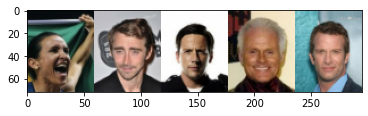

[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]]


In [68]:
# np.hstack은 height 방향의 배열을 풀어서 width 방향으로 연결해줍니다.
# 해당 기능을 쓰면 (height, image_height, image_width, color)의 shape을 (image_height, image_width * height, color)으로 바꿔 줄 수 있습니다.
# 코드를 작성해보세요.
plt.imshow(np.hstack(train_images[:5]))
plt.show()
print(train_labels2[:5])

### 문제 17. np.hstack은 tensorflow에서 제공하는 방법이 아니므로 transpose 함수를 이용하여 (세로, 가로 * 5, 3)로 shape을 변경해보세요.

In [74]:
# transpose는 tensor의 axis를 섞는 기능을 합니다.
# 해당 기능을 이용해서 (세로, 가로 * 5, 3)을 작성하는 코드를 작성해보세요.
train_images[:5].transpose((1, 0, 2, 3)).reshape((72, -1, 3)).shape

(72, 295, 3)

### 문제 18. (72, 295, 3)이 된 tensor를 plt로 출력해보세요.

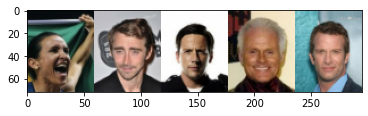

In [73]:
# (72, 295, 3)의 이미지를 plt로 출력해보세요.
plt.imshow(train_images[:5].transpose((1, 0, 2, 3)).reshape((72, -1, 3)))
plt.show()

### 문제 19. smile, male label도 5개 출력해보세요.

In [76]:
# smile, male label을 5개 출력하는 코드를 작성해보세요.
for male, smile in zip(train_male_labels[:5], train_smile_labels[:5]):
  print(male, smile)

'''
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]]
 '''

[1. 0.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [0. 1.]


### 문제 20. smile, male이 각각 몇개 있는지 측정해보세요.

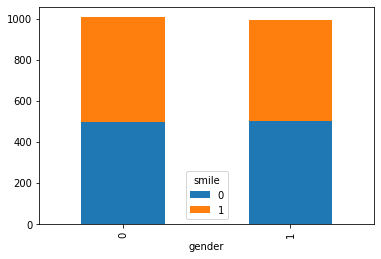

In [81]:
# pandas를 smile, male이 각각 몇개 있는지 plt를 통하여 출력하는 코드를 작성하세요.
df = pd.DataFrame(train_labels, columns = ['gender', 'smile'])
df.groupby(['gender', 'smile']).size().unstack().plot(kind='bar', stacked=True)

## Step 4. 각각 모델링

### 문제 21. smile과 gender 학습셋을 각 각 처리하는 이미지 classification 모델 2개를 작성하세요. (단 label을 각각 따로 처리)

In [87]:
# input (배치, 72, 59, 3), output (배치, 2)을 처리할 수 있는 모양의 모델 2개를 작성하세요.
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten

def simple_model():
  inputs = Input((72, 59, 3))

  x = Conv2D(32, 3, activation='relu')(inputs)
  x = MaxPool2D(2)(x)
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPool2D(2)(x)
  
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)

  outputs = Dense(2, activation='softmax')(x)
  model = Model(inputs, outputs)
  return model

### 문제 22. 2개의 모델을 할당 받고 서머리를 출력해보세요.

In [103]:
# simple_model() 모델을 2번 할당 받고 서머리를 출력하는 코드를 작성하세요.
gender_model = simple_model()
smile_model = simple_model()

In [104]:
gender_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 5, 64)          0   

In [105]:
smile_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 5, 64)          0   

### 문제 23. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [106]:
# 만든 모델에 loss는 categorical_crossentropy, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
gender_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
smile_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [107]:
gender_model.get_weights()[0][0][0][0]

array([ 0.00367439,  0.13224675,  0.09439218,  0.08547479,  0.04456539,
        0.09234388,  0.0980076 ,  0.0080336 ,  0.03755616, -0.06940513,
        0.05791925, -0.11957719, -0.1334111 , -0.08047421,  0.10786605,
        0.01244542, -0.06822967,  0.07988155, -0.12496774, -0.00653563,
       -0.03750578,  0.10323645, -0.13429834, -0.0885127 ,  0.10301247,
       -0.11899714,  0.12251841,  0.05084723,  0.12263538, -0.13262796,
       -0.09233142,  0.03141285], dtype=float32)

In [108]:
smile_model.get_weights()[0][0][0][0]

array([ 0.09843744, -0.07024516,  0.06048708, -0.0878121 ,  0.1108418 ,
        0.00660293,  0.06663921, -0.07285847,  0.06128763, -0.01924308,
        0.04156625,  0.12465425,  0.11826088, -0.08311051,  0.03211866,
       -0.04065113, -0.10079281, -0.11762277, -0.13432214, -0.11106776,
       -0.00395122, -0.02352621,  0.00113936, -0.019167  , -0.00940126,
       -0.08241336, -0.00795157, -0.11312491,  0.00872661, -0.03508332,
        0.02482516, -0.12148518], dtype=float32)

### 문제 24. 만든 모델에 train_images를 학습시켜 보세요.

In [109]:
# train_images 학습시키고 15 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
gender_hist = gender_model.fit(train_images, train_male_labels, validation_data=(test_images, test_male_labels), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 1s 11ms/step - loss: 0.6797 - accuracy: 0.5650 - val_loss: 0.5609 - val_accuracy: 0.7450
Epoch 2/15
63/63 [==============================] - 1s 10ms/step - loss: 0.5303 - accuracy: 0.7513 - val_loss: 0.6245 - val_accuracy: 0.7150
Epoch 3/15
63/63 [==============================] - 0s 7ms/step - loss: 0.4587 - accuracy: 0.7904 - val_loss: 0.4829 - val_accuracy: 0.8000
Epoch 4/15
63/63 [==============================] - 0s 6ms/step - loss: 0.3890 - accuracy: 0.8178 - val_loss: 0.3863 - val_accuracy: 0.8550
Epoch 5/15
63/63 [==============================] - 0s 6ms/step - loss: 0.2738 - accuracy: 0.8889 - val_loss: 0.3454 - val_accuracy: 0.8750
Epoch 6/15
63/63 [==============================] - 0s 6ms/step - loss: 0.2187 - accuracy: 0.9136 - val_loss: 0.3706 - val_accuracy: 0.8800
Epoch 7/15
63/63 [==============================] - 0s 6ms/step - loss: 0.1621 - accuracy: 0.9352 - val_loss: 0.3057 - val_accuracy: 0.9200
Epoch 8/15
63/63 [

In [110]:
gender_model.get_weights()[0][0][0][0]

array([ 0.01627052,  0.12876533,  0.15856816,  0.05913284,  0.0543971 ,
        0.13678728,  0.19305119, -0.0560741 , -0.00681798, -0.09930672,
        0.03009751, -0.18606809, -0.14468792, -0.09664426, -0.00533943,
        0.0122426 , -0.11832729,  0.05304939, -0.16086376, -0.04355757,
       -0.06279481,  0.11433551, -0.14594431, -0.14815204,  0.145787  ,
       -0.152339  ,  0.21537839,  0.1024059 ,  0.09619188, -0.08638398,
       -0.05931306,  0.01014957], dtype=float32)

In [111]:
smile_model.get_weights()[0][0][0][0]

array([ 0.09843744, -0.07024516,  0.06048708, -0.0878121 ,  0.1108418 ,
        0.00660293,  0.06663921, -0.07285847,  0.06128763, -0.01924308,
        0.04156625,  0.12465425,  0.11826088, -0.08311051,  0.03211866,
       -0.04065113, -0.10079281, -0.11762277, -0.13432214, -0.11106776,
       -0.00395122, -0.02352621,  0.00113936, -0.019167  , -0.00940126,
       -0.08241336, -0.00795157, -0.11312491,  0.00872661, -0.03508332,
        0.02482516, -0.12148518], dtype=float32)

In [112]:
smile_hist = smile_model.fit(train_images, train_smile_labels, validation_data=(test_images, test_smile_labels), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 1s 10ms/step - loss: 0.7025 - accuracy: 0.5004 - val_loss: 0.6941 - val_accuracy: 0.4850
Epoch 2/15
63/63 [==============================] - 0s 7ms/step - loss: 0.6765 - accuracy: 0.5681 - val_loss: 0.6211 - val_accuracy: 0.6500
Epoch 3/15
63/63 [==============================] - 0s 6ms/step - loss: 0.6227 - accuracy: 0.6550 - val_loss: 0.5494 - val_accuracy: 0.7350
Epoch 4/15
63/63 [==============================] - 0s 6ms/step - loss: 0.5526 - accuracy: 0.7141 - val_loss: 0.4416 - val_accuracy: 0.7800
Epoch 5/15
63/63 [==============================] - 0s 6ms/step - loss: 0.4088 - accuracy: 0.8174 - val_loss: 0.3215 - val_accuracy: 0.8650
Epoch 6/15
63/63 [==============================] - 0s 6ms/step - loss: 0.3325 - accuracy: 0.8584 - val_loss: 0.2876 - val_accuracy: 0.8700
Epoch 7/15
63/63 [==============================] - 0s 6ms/step - loss: 0.2569 - accuracy: 0.8978 - val_loss: 0.2575 - val_accuracy: 0.9050
Epoch 8/15
63/63 [=

In [113]:
smile_model.get_weights()[0][0][0][0]

array([ 0.07612935, -0.07858768,  0.06324714, -0.09898362,  0.14575306,
        0.03293602,  0.1568636 , -0.06779952,  0.03197577, -0.02378239,
        0.05731003,  0.1110534 ,  0.14929014, -0.11530948,  0.00944987,
       -0.04805611, -0.10298581, -0.10844994, -0.1213631 , -0.10686163,
        0.01655999,  0.0137252 , -0.0197967 ,  0.03174854,  0.00408492,
       -0.11061637, -0.02565053, -0.11238087,  0.0144214 , -0.03841697,
        0.01655924, -0.09319049], dtype=float32)

### 문제 25. 학습 진행 사항을 plt으로 출력하세요.

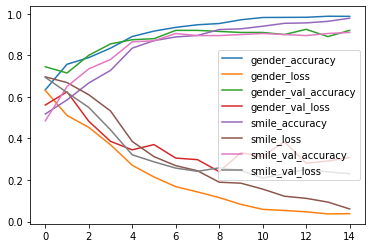

In [114]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(gender_hist.history['accuracy'], label = 'gender_accuracy')
plt.plot(gender_hist.history['loss'], label = 'gender_loss')
plt.plot(gender_hist.history['val_accuracy'], label = 'gender_val_accuracy')
plt.plot(gender_hist.history['val_loss'], label = 'gender_val_loss')

plt.plot(smile_hist.history['accuracy'], label = 'smile_accuracy')
plt.plot(smile_hist.history['loss'], label = 'smile_loss')
plt.plot(smile_hist.history['val_accuracy'], label = 'smile_val_accuracy')
plt.plot(smile_hist.history['val_loss'], label = 'smile_val_loss')

plt.legend(loc='uppder left')
plt.show()

## Step 5. 결과 확인

### 문제 26. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [126]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
gender_res = gender_model.predict(test_images[1:2])
gender_res.shape

(1, 2)

In [127]:
smile_res = smile_model.predict(test_images[1:2])
smile_res.shape

(1, 2)

### 문제 27. res와 test_images[1]을 plt로 출력하세요

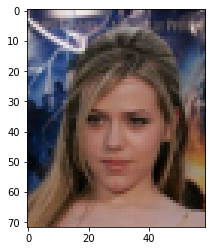

In [128]:
# res와 test_images[1]을 print와 plt로 출력하는 코드를 작성하세요.
plt.imshow(test_images[1])
plt.show()

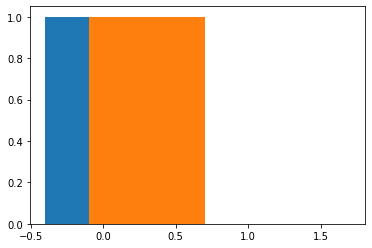

[[9.9993765e-01 6.2339459e-05]]


In [129]:
plt.bar(range(2), gender_res[0])
plt.bar(np.array(range(2)) + 0.3, test_male_labels[1])
plt.show()
print(gender_res)

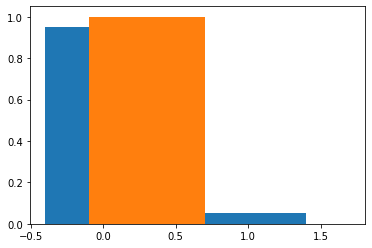

[[0.9493317  0.05066829]]


In [130]:
plt.bar(range(2), smile_res[0])
plt.bar(np.array(range(2)) + 0.3, test_smile_labels[1])
plt.show()
print(smile_res)

## Step 6. 멀티 아웃풋 모델링

### 문제 28. 해당 학습셋을 처리하는 이미지 classification 모델을 작성하세요. (단 label을 2개 동시에 처리)

In [155]:
# input (배치, 72, 59, 3), output (배치, 2)을 처리할 수 있는 모양의 모델을 작성하세요.
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten, Concatenate

def multi_model():
  inputs = Input((72, 59, 3))

  l1 = Conv2D(32, 3, activation='relu')(inputs)
  l2 = MaxPool2D(2)(l1)
  l3 = Conv2D(64, 3, activation='relu')(l2)
  l4 = MaxPool2D(2)(l3)
  l5 = Conv2D(64, 3, activation='relu')(l4)
  l6 = MaxPool2D(2)(l5)
  
  l7 = Flatten()(l6)
  latent_vector = Dense(64, activation='relu')(l7)

  gender_outputs = Dense(2, activation='softmax')(latent_vector)
  smile_outputs = Dense(2, activation='softmax')(latent_vector)

  outputs = Concatenate(axis=1)([gender_outputs, smile_outputs])
  model = Model(inputs, outputs)
  #model = Model(inputs, [gender_outputs, smile_outputs])
  return model

In [135]:
model2 = multi_model()
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 70, 57, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 35, 28, 32)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 33, 26, 64)   18496       max_pooling2d_24[0][0]           
____________________________________________________________________________________________

### 문제 29. 모델을 할당 받고 서머리를 출력해보세요.

In [156]:
# multi_model() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = multi_model()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 70, 57, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 35, 28, 32)   0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 33, 26, 64)   18496       max_pooling2d_33[0][0]           
____________________________________________________________________________________________

### 문제 30. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [157]:
# 만든 모델에 loss는 categorical_crossentropy, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [138]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 문제 31. 만든 모델에 train_images를 학습시켜 보세요.

In [158]:
# train_images 학습시키고 15 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist1 = model.fit(train_images, train_labels2, validation_data=(test_images, test_labels2), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 1s 10ms/step - loss: 2.7372 - accuracy: 0.3118 - val_loss: 2.5917 - val_accuracy: 0.6150
Epoch 2/15
63/63 [==============================] - 0s 7ms/step - loss: 2.5503 - accuracy: 0.6668 - val_loss: 2.5047 - val_accuracy: 0.6200
Epoch 3/15
63/63 [==============================] - 0s 6ms/step - loss: 2.3810 - accuracy: 0.6677 - val_loss: 2.5069 - val_accuracy: 0.5950
Epoch 4/15
63/63 [==============================] - 0s 6ms/step - loss: 2.1375 - accuracy: 0.6725 - val_loss: 2.1756 - val_accuracy: 0.5900
Epoch 5/15
63/63 [==============================] - 0s 6ms/step - loss: 1.9595 - accuracy: 0.6786 - val_loss: 2.0968 - val_accuracy: 0.5700
Epoch 6/15
63/63 [==============================] - 0s 6ms/step - loss: 1.8910 - accuracy: 0.6437 - val_loss: 1.9641 - val_accuracy: 0.5750
Epoch 7/15
63/63 [==============================] - 0s 7ms/step - loss: 1.7786 - accuracy: 0.6553 - val_loss: 2.0509 - val_accuracy: 0.5800
Epoch 8/15
63/63 [=

In [143]:
# train_images 학습시키고 15 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist2 = model2.fit(train_images, [train_male_labels, train_smile_labels], validation_data=(test_images, [test_male_labels, test_smile_labels]), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 1s 13ms/step - loss: 1.3845 - dense_19_loss: 0.6870 - dense_20_loss: 0.6974 - dense_19_accuracy: 0.5675 - dense_20_accuracy: 0.5476 - val_loss: 1.2526 - val_dense_19_loss: 0.5884 - val_dense_20_loss: 0.6642 - val_dense_19_accuracy: 0.6700 - val_dense_20_accuracy: 0.5750
Epoch 2/15
63/63 [==============================] - 1s 8ms/step - loss: 1.1968 - dense_19_loss: 0.5279 - dense_20_loss: 0.6689 - dense_19_accuracy: 0.7495 - dense_20_accuracy: 0.5942 - val_loss: 1.1513 - val_dense_19_loss: 0.5460 - val_dense_20_loss: 0.6053 - val_dense_19_accuracy: 0.7500 - val_dense_20_accuracy: 0.7000
Epoch 3/15
63/63 [==============================] - 0s 8ms/step - loss: 1.0471 - dense_19_loss: 0.4377 - dense_20_loss: 0.6094 - dense_19_accuracy: 0.8098 - dense_20_accuracy: 0.6648 - val_loss: 0.9903 - val_dense_19_loss: 0.4907 - val_dense_20_loss: 0.4996 - val_dense_19_accuracy: 0.8000 - val_dense_20_accuracy: 0.7400
Epoch 4/15
63/63 [===============

### 문제 32. 학습 진행 사항을 plt으로 출력하세요.

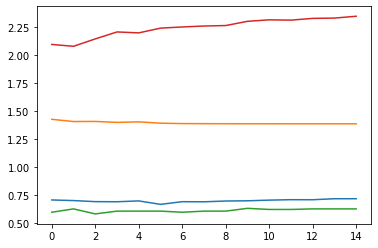

In [144]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist1.history['accuracy'], label = 'accuracy')
plt.plot(hist1.history['loss'], label = 'loss')
plt.plot(hist1.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist1.history['val_loss'], label = 'val_loss')
plt.show()

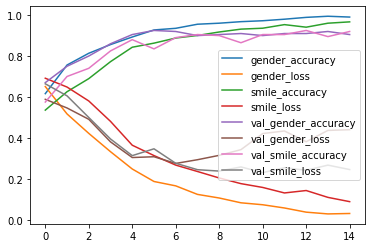

In [147]:
plt.plot(hist2.history['dense_19_accuracy'], label = 'gender_accuracy')
plt.plot(hist2.history['dense_19_loss'], label = 'gender_loss')
plt.plot(hist2.history['dense_20_accuracy'], label = 'smile_accuracy')
plt.plot(hist2.history['dense_20_loss'], label = 'smile_loss')

plt.plot(hist2.history['val_dense_19_accuracy'], label = 'val_gender_accuracy')
plt.plot(hist2.history['val_dense_19_loss'], label = 'val_gender_loss')
plt.plot(hist2.history['val_dense_20_accuracy'], label = 'val_smile_accuracy')
plt.plot(hist2.history['val_dense_20_loss'], label = 'val_smile_loss')
plt.legend(loc = 'uppder left')
plt.show()

## Step 7. 결과 확인

### 문제 33. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [177]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model2.predict(test_images[3:4])
print(len(res))
print(res[0].shape, res[1].shape)

2
(1, 2) (1, 2)


In [175]:
res2 = model.predict(test_images[3:4])
print(res2.shape)

(1, 4)


### 문제 34. res와 test_images[1]을 plt로 출력하세요

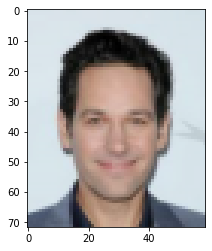

In [176]:
# res와 test_images[1]을 print와 plt로 출력하는 코드를 작성하세요.
plt.imshow(test_images[3])
plt.show()

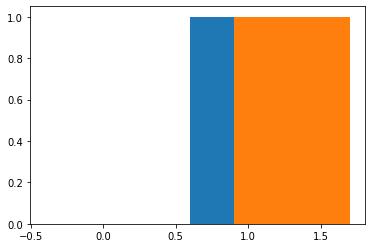

In [178]:
plt.bar(range(2), res[0][0])
plt.bar(np.array(range(2)) + 0.3, test_male_labels[3])
plt.show()

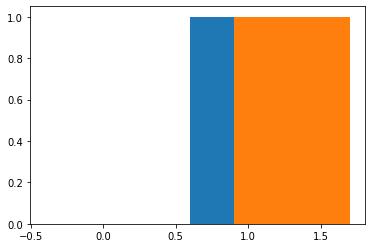

In [179]:
plt.bar(range(2), res[1][0])
plt.bar(np.array(range(2)) + 0.3, test_smile_labels[3])
plt.show()

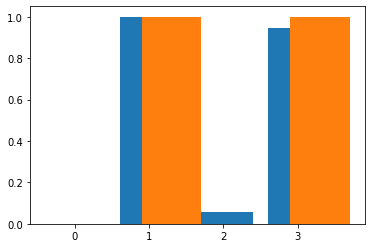

In [180]:
plt.bar(range(4), res2[0])
plt.bar(np.array(range(4)) + 0.3, test_labels2[3])
plt.show()

## Step 8. 모델 분리

###문제 35. model의 뒷단을 수정하여 성별 모델을 분리해보세요.

In [182]:
# model의 뒷단을 수정하여 성별 모델을 분리하고 모델 정보를 확인하는 코드를 작성하세요.
gender_model2 = Model(inputs = model2.input, outputs = model2.get_layer('dense_19').output)
gender_model2.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 7, 5, 64)          0   

In [190]:
gender_model2.get_weights()[0][0][0][0]

array([-0.01324298, -0.0298002 , -0.16033392,  0.01527557, -0.0922309 ,
        0.10909493,  0.00912538,  0.09817191, -0.10975034,  0.06473815,
        0.00518415,  0.19328082, -0.08926127, -0.11115279,  0.18214278,
       -0.15751666, -0.00996949,  0.1004896 ,  0.10054359,  0.16610207,
       -0.00584195,  0.09622023, -0.00557665, -0.15161063,  0.08541303,
       -0.08204915, -0.19083166,  0.10660474, -0.07228048, -0.0520462 ,
       -0.16323906,  0.09354263], dtype=float32)

In [189]:
smile_model2.get_weights()[0][0][0][0]

array([-0.01324298, -0.0298002 , -0.16033392,  0.01527557, -0.0922309 ,
        0.10909493,  0.00912538,  0.09817191, -0.10975034,  0.06473815,
        0.00518415,  0.19328082, -0.08926127, -0.11115279,  0.18214278,
       -0.15751666, -0.00996949,  0.1004896 ,  0.10054359,  0.16610207,
       -0.00584195,  0.09622023, -0.00557665, -0.15161063,  0.08541303,
       -0.08204915, -0.19083166,  0.10660474, -0.07228048, -0.0520462 ,
       -0.16323906,  0.09354263], dtype=float32)

### 문제 36. 성별모델에서 테스트 데이터 확인

In [194]:
# 성별모델에서 테스트 데이터 확인
x = gender_model2.predict(test_images[0:1])
x.argmax()

1

### 문제 37. 뒷단을 수정하여 smile 모델을 분리해보세요.

In [183]:
# model의 뒷단을 수정하여 smile 모델을 분리하고 정보를 확인하는 코드를 작성하세요.
smile_model2 = Model(inputs = model2.input, outputs = model2.get_layer('dense_20').output)
smile_model2.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 7, 5, 64)          0  

### 문제 38. 스마일 모델에서 테스트 데이터 확인

In [195]:
# 스마일 모델에서 테스트 데이터 확인
x1 = gender_model2.predict(test_images[0:1])
x1.argmax()

1

## Step 9. 통합 모델 저장 및 로드, 다운

### 문제 39. 모델을 저장하세요.

In [196]:
# 모델을 저장하는 코드를 작성하세요.
model2.save("./lecture004.h5")

In [197]:
!ls -al /content

total 172312
drwxr-xr-x 1 root root      4096 Dec 26 08:21 .
drwxr-xr-x 1 root root      4096 Dec 26 05:47 ..
-rw-r--r-- 1 root root 173961605 Dec 26 05:50 celeba_small.npz
drwxr-xr-x 1 root root      4096 Dec 21 17:29 .config
-rw-r--r-- 1 root root   2462152 Dec 26 08:21 lecture004.h5
drwxr-xr-x 1 root root      4096 Dec 21 17:29 sample_data


### 문제 40. 모델 파일을 새로운 모델에 로드하세요.

In [198]:
# 모델을 로드하는 코드를 작성하세요.
model3 = tf.keras.models.load_model('./lecture004.h5')

In [199]:
model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 70, 57, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 35, 28, 32)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 33, 26, 64)   18496       max_pooling2d_24[0][0]           
____________________________________________________________________________________________

In [200]:
model3.get_weights()[0][0][0][0]

array([-0.01324298, -0.0298002 , -0.16033392,  0.01527557, -0.0922309 ,
        0.10909493,  0.00912538,  0.09817191, -0.10975034,  0.06473815,
        0.00518415,  0.19328082, -0.08926127, -0.11115279,  0.18214278,
       -0.15751666, -0.00996949,  0.1004896 ,  0.10054359,  0.16610207,
       -0.00584195,  0.09622023, -0.00557665, -0.15161063,  0.08541303,
       -0.08204915, -0.19083166,  0.10660474, -0.07228048, -0.0520462 ,
       -0.16323906,  0.09354263], dtype=float32)

### 문제 41. 로드한 모델을 test 데이터로 평가해보세요.


In [201]:
# 로드한 모델을 test 데이터로 평가해보세요.
model3.evaluate(test_images, [test_male_labels, test_smile_labels])

7/7 [==============================] - 0s 5ms/step - loss: 0.6848 - dense_19_loss: 0.4398 - dense_20_loss: 0.2450 - dense_19_dense_19_accuracy: 0.9050 - dense_20_dense_20_accuracy: 0.9200


[0.6848430633544922,
 0.43981924653053284,
 0.24502387642860413,
 0.9049999713897705,
 0.9200000166893005]

### 문제 42. 모델을 내 컴퓨터에 저장해보세요

In [203]:
# 모델을 내 컴퓨터에 저장해보세요.
from google.colab import files
files.download('./lecture004.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>